# Dataset and Feature importance analysis


In [1]:
import warnings
warnings.filterwarnings('ignore')

import json
import string
import time
import math
import os

import pandas as pd
import numpy as np
import statistics as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from pathlib import Path

In [2]:
annotations_file = Path(r"../DVlog/dataset/dvlog_labels_v2.csv")
pdem_features_path = Path(r"E:/master/data/PDEM/pdem-dataset")
text_embeddings_path = Path(r"E:/master/data/embeddings-dataset")

In [3]:
# load in the annotation labels
df_annotations = pd.read_csv(annotations_file)
df_annotations.head()

,video_id,label,gender,dataset
0,0,1,f,train
1,1,1,f,test
2,2,1,m,train
3,3,1,m,train
4,4,1,f,test


## Retrieve information regarding the PDEM features

In [4]:
pdem_info_dict = {}

for index, row in df_annotations.iterrows():

    video_id = str(row.video_id)
    vad_file_path = os.path.join(pdem_features_path, video_id, "pdemvad.npy")
    embeddings = np.load(vad_file_path).astype(np.float32)

    # save the info
    pdem_info_dict[video_id] = {
        "embedding": embeddings,
        "seq_length": embeddings.shape[0],
        "arousal": 1,
        "dominance": 1,
        "valence": 1
    }

In [5]:
# put the information back into the dataframe
df_annotations["pdem_seq_length"] = df_annotations["video_id"].apply(lambda x: pdem_info_dict.get(str(x)).get("seq_length"))

print(f"mean length: {df_annotations['pdem_seq_length'].mean()}\nmax length: {df_annotations['pdem_seq_length'].max()}")

df_annotations.head()

mean length: 101.10157194679564
max length: 753


,video_id,label,gender,dataset,pdem_seq_length
0,0,1,f,train,164
1,1,1,f,test,69
2,2,1,m,train,119
3,3,1,m,train,77
4,4,1,f,test,90


<Figure size 640x480 with 0 Axes>

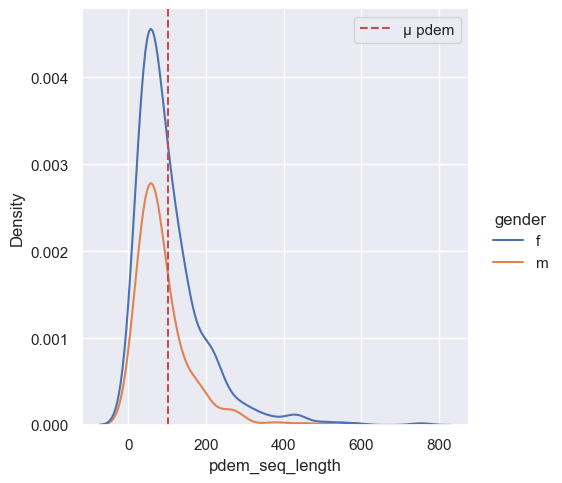

In [6]:
# Get the distribution for both the male and female extracted features
plt.figure()

# plot the data
sns.displot(df_annotations, x="pdem_seq_length", hue="gender", kind="kde")

# plot the vertical mean line
x_mean = df_annotations['pdem_seq_length'].mean()
plt.axvline(x_mean, color='r', ls='--', label=f"μ pdem")

plt.legend()
plt.show()

## Retrieve and plot information regarding the word and sentence embeddings

In [7]:
embed_info_dict = {}

for index, row in df_annotations.iterrows():

    video_id = str(row.video_id)
    embeddings_file_path = os.path.join(text_embeddings_path, video_id)
    embed_info_dict[video_id] = {
        "w2v_seconds": np.load(os.path.join(embeddings_file_path, "w2v_seconds_normal_avg.npy")).astype(np.float32).shape[0],
        "w2v_sentences": np.load(os.path.join(embeddings_file_path, "w2v_seq_avg.npy")).astype(np.float32).shape[0],
        "w2v_keywords": np.load(os.path.join(embeddings_file_path, "w2v_seq_avg_keyw.npy")).astype(np.float32).shape[0]
    }

In [8]:
# put the features back into the dataframe
df_annotations["w2v_seconds"] = df_annotations["video_id"].apply(lambda x: embed_info_dict.get(str(x)).get("w2v_seconds"))
df_annotations["w2v_sentences"] = df_annotations["video_id"].apply(lambda x: embed_info_dict.get(str(x)).get("w2v_sentences"))
df_annotations["w2v_keywords"] = df_annotations["video_id"].apply(lambda x: embed_info_dict.get(str(x)).get("w2v_keywords"))

df_annotations.head()

,video_id,label,gender,dataset,pdem_seq_length,w2v_seconds,w2v_sentences,w2v_keywords
0,0,1,f,train,164,813,155,150
1,1,1,f,test,69,424,69,58
2,2,1,m,train,119,835,119,112
3,3,1,m,train,77,419,77,69
4,4,1,f,test,90,430,80,79


mean length: 578.01


<Figure size 640x480 with 0 Axes>

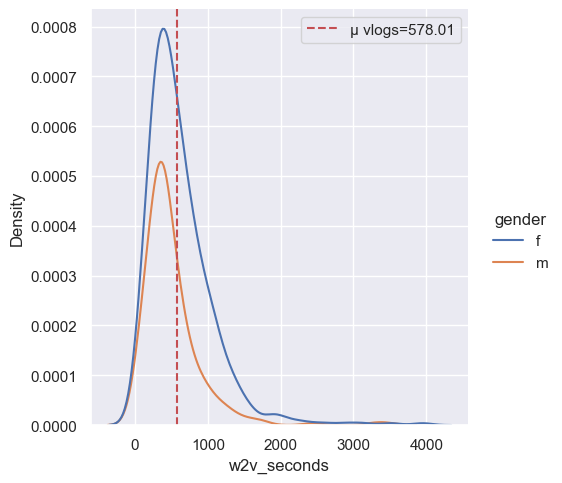

In [9]:
# Get the distribution for both the male and female extracted features
mean_length = round(df_annotations['w2v_seconds'].mean(), 2)
print(f"mean length: {mean_length}")

plt.figure()

# plot the data
sns.displot(df_annotations, x="w2v_seconds", hue="gender", kind="kde")

# plot the vertical mean line
x_mean = df_annotations['w2v_seconds'].mean()
plt.axvline(x_mean, color='r', ls='--', label=f"μ vlogs={mean_length}")

plt.legend()
plt.show()

        avg_duration
gender              
f         104.230627
m          88.368421


<Figure size 640x480 with 0 Axes>

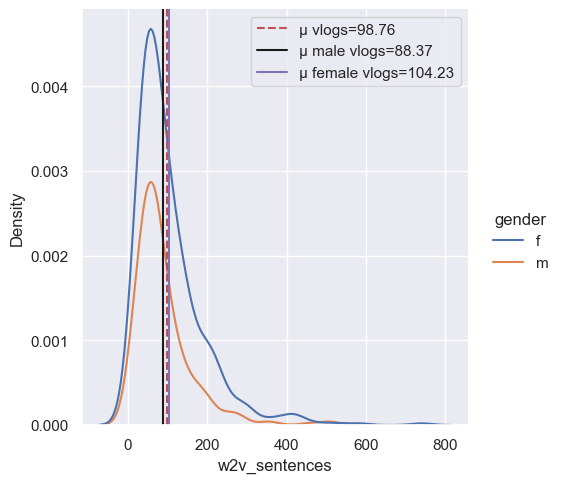

In [10]:
# get the length of the sentences with the mean per label and overall
mean_length = round(df_annotations['w2v_sentences'].mean(), 2)
gender_length = df_annotations.groupby(["gender"]).agg(avg_duration=("w2v_sentences", "mean"))
f_length, m_length = round(gender_length.loc["f"]["avg_duration"], 2), round(gender_length.loc["m"]["avg_duration"], 2)
print(gender_length)
# plot the figure
plt.figure()

# plot the data
sns.displot(df_annotations, x="w2v_sentences", hue="gender", kind="kde")

# plot the vertical mean line
plt.axvline(mean_length, color='r', ls='--', label=f"μ vlogs={mean_length}")
plt.axvline(m_length, color='k', ls='-', label=f"μ male vlogs={m_length}")
plt.axvline(f_length, color='m', ls='-', label=f"μ female vlogs={f_length}")

plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

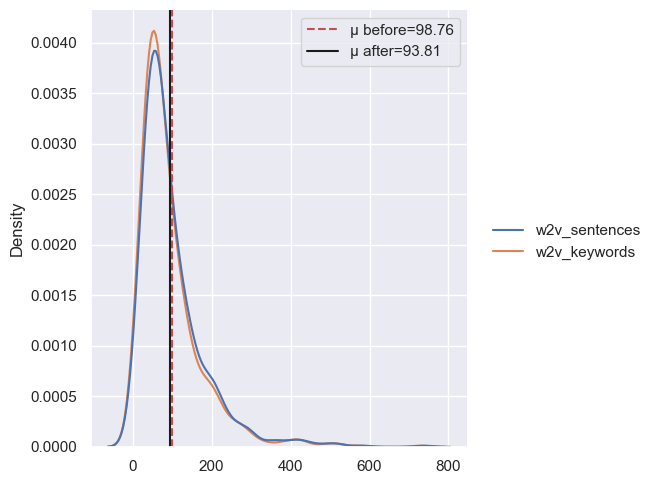

In [22]:
# get the length of the sentences with the mean per label and overall
norm_length, keyw_length = round(df_annotations['w2v_sentences'].mean(), 2), round(df_annotations['w2v_keywords'].mean(), 2)

# plot the data
plt.figure()

sns.displot([df_annotations["w2v_sentences"], df_annotations["w2v_keywords"]], kind="kde")
# sns.displot(df_annotations, x="w2v_keywords", kind="kde")

# plot the vertical mean line
plt.axvline(norm_length, color='r', ls='--', label=f"μ before={norm_length}")
plt.axvline(keyw_length, color='k', ls='-', label=f"μ after={keyw_length}")

plt.legend()
plt.show()